## Dependencies

In [1]:
import warnings, time
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import optimizers, Sequential, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from cassava_scripts import *


seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

In [2]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
strategy, tpu = set_up_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [3]:
BATCH_SIZE = 16 * REPLICAS
LEARNING_RATE = 3e-5 * REPLICAS
EPOCHS = 13
HEIGHT = 512
WIDTH = 512
HEIGHT_DT = 512
WIDTH_DT = 512
CHANNELS = 3
N_CLASSES = 5
N_FOLDS = 5
FOLDS_USED = 1
ES_PATIENCE = 5

# Load data

In [4]:
database_base_path = '/kaggle/input/cassava-leaf-disease-classification/'
train = pd.read_csv(f'{database_base_path}train.csv')
print(f'Train samples: {len(train)}')

GCS_PATH = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-center-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord)
# GCS_PATH_EXT = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-external-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord) (External)
# GCS_PATH_CLASSES = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-classes-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord) by classes
# GCS_PATH_EXT_CLASSES = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-classes-ext-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord) (External) by classes


FILENAMES_COMP = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')
# FILENAMES_2019 = tf.io.gfile.glob(GCS_PATH_EXT + '/*.tfrec')

# FILENAMES_COMP_CBB = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBB*.tfrec')
# FILENAMES_COMP_CBSD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBSD*.tfrec')
# FILENAMES_COMP_CGM = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CGM*.tfrec')
# FILENAMES_COMP_CMD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CMD*.tfrec')
# FILENAMES_COMP_Healthy = tf.io.gfile.glob(GCS_PATH_CLASSES + '/Healthy*.tfrec')

# FILENAMES_2019_CBB = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBB*.tfrec')
# FILENAMES_2019_CBSD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBSD*.tfrec')
# FILENAMES_2019_CGM = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CGM*.tfrec')
# FILENAMES_2019_CMD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CMD*.tfrec')
# FILENAMES_2019_Healthy = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/Healthy*.tfrec')

TRAINING_FILENAMES = FILENAMES_COMP
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

Train samples: 21397
GCS: train images: 21395


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Augmentation

In [5]:
def data_augment(image, label):
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .2:
        crop_size = tf.random.uniform([], int(HEIGHT_DT*.6), HEIGHT_DT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])

    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

#     if p_cutout > .5:
#         image = data_augment_cutout(image)
        
    return image, label

## Auxiliary functions

In [6]:
# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    images /= 255.
    labels = np.argmax(labels, axis=-1)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [7]:
# Datasets utility functions
def random_crop(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.random_crop(image, size=[HEIGHT, WIDTH, CHANNELS])
    return image, label

def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image, label

def center_crop_(image, label, height_rs, width_rs, height=HEIGHT_DT, width=WIDTH_DT, channels=3):
    image = tf.reshape(image, [height, width, channels]) # Original shape
    
    h, w = image.shape[0], image.shape[1]
    if h > w:
        image = tf.image.crop_to_bounding_box(image, (h - w) // 2, 0, w, w)
    else:
        image = tf.image.crop_to_bounding_box(image, 0, (w - h) // 2, h, h)
        
    image = tf.image.resize(image, [height_rs, width_rs]) # Expected shape
    return image, label


def read_tfrecord_(example, labeled=True, sparse=True, n_classes=5):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
        if not sparse: # One-Hot Encoding needed to use "categorical_crossentropy" loss
            label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), n_classes)
    else:
        label_or_name = example['image_name']
    return image, label_or_name

def get_dataset(filenames, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False, batch_size=BATCH_SIZE, sparse=True):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(filenames)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda x: read_tfrecord_(x, labeled=labeled, sparse=sparse), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(batch_size)
    
    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

# Training data samples (with augmentation)

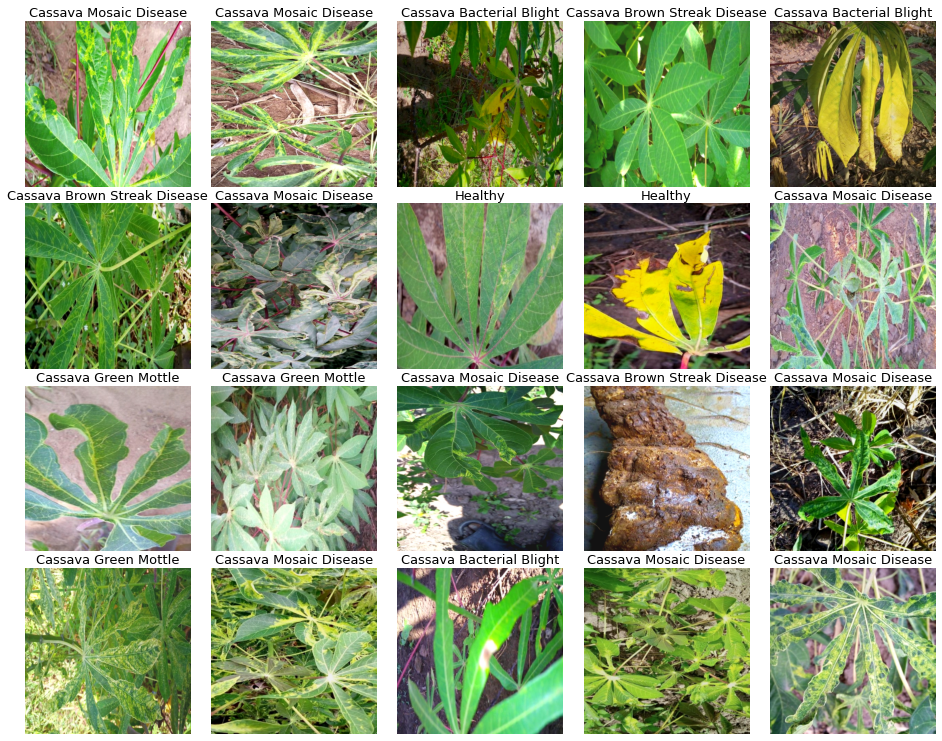

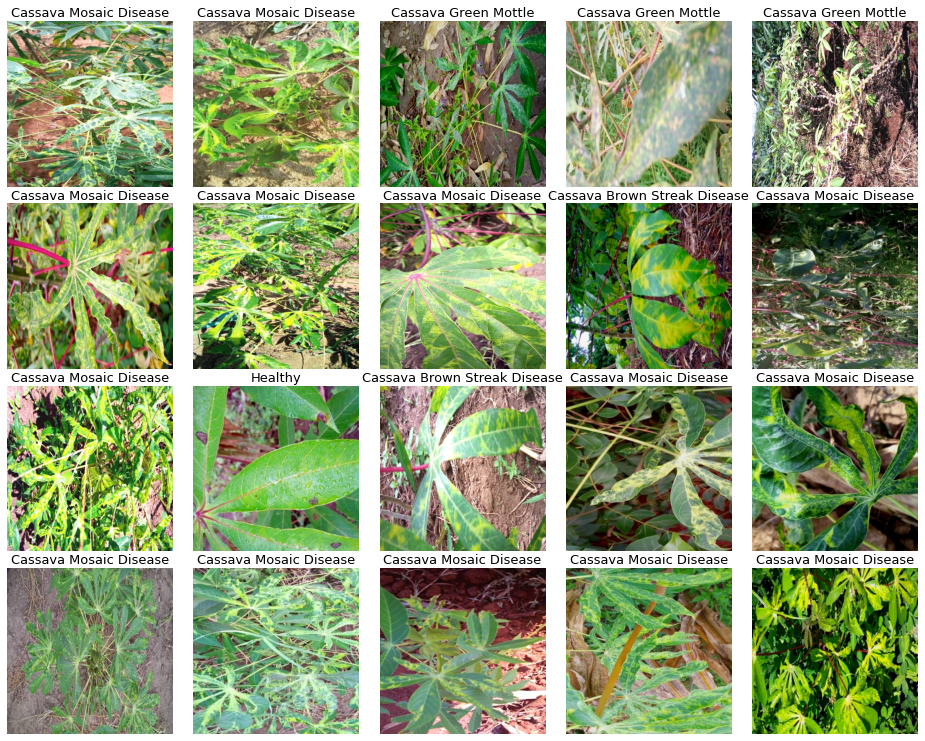

In [8]:
train_dataset = get_dataset(FILENAMES_COMP, ordered=True, augment=True, sparse=False)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

In [9]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b4.tar.gz
!tar -xf noisy_student_efficientnet-b4.tar.gz

--2021-02-15 16:39:24--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 173.194.217.128, 74.125.134.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143203873 (137M) [application/gzip]
Saving to: ‘noisy_student_efficientnet-b4.tar.gz’

noisy_student_effic 100%[===================>] 136.57M   192MB/s    in 0.7s    

2021-02-15 16:39:25 (192 MB/s) - ‘noisy_student_efficientnet-b4.tar.gz’ saved [143203873/143203873]



In [10]:
def write_ckpt_to_h5(path_h5, path_ckpt, keras_model, use_ema=True):
  """Map the weights in checkpoint file (tf) to h5 file (keras).
  Args:
    path_h5: str, path to output hdf5 file to write weights loaded from ckpt
      files.
    path_ckpt: str, path to the ckpt files (e.g. 'efficientnet-b0/model.ckpt')
      that records efficientnet weights from original repo
      https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet
    keras_model: keras model, built from keras.applications efficientnet
      functions (e.g. EfficientNetB0)
    use_ema: Bool, whether to use ExponentialMovingAverage result or not
  """
  model_name_keras = keras_model.name
  model_name_tf = model_name_keras.replace('efficientnet', 'efficientnet-')

  keras_weight_names = [w.name for w in keras_model.weights]
  tf_weight_names = get_variable_names_from_ckpt(path_ckpt)

  keras_blocks = get_keras_blocks(keras_weight_names)
  tf_blocks = get_tf_blocks(tf_weight_names)

  print('check variables match in each block')
  for keras_block, tf_block in zip(keras_blocks, tf_blocks):
    check_match(keras_block, tf_block, keras_weight_names, tf_weight_names,
                model_name_tf)
    print('{} and {} match.'.format(tf_block, keras_block))

  block_mapping = {x[0]: x[1] for x in zip(keras_blocks, tf_blocks)}

  changed_weights = 0
  for w in keras_model.weights:
    if 'block' in w.name:
      # example: 'block1a_dwconv/depthwise_kernel:0' -> 'block1a'
      keras_block = w.name.split('/')[0].split('_')[0]
      tf_block = block_mapping[keras_block]
      tf_name = keras_name_to_tf_name_block(
          w.name,
          keras_block=keras_block,
          tf_block=tf_block,
          use_ema=use_ema,
          model_name_tf=model_name_tf)
    elif any([x in w.name for x in ['stem', 'top', 'predictions', 'probs']]):
      tf_name = keras_name_to_tf_name_stem_top(
          w.name, use_ema=use_ema, model_name_tf=model_name_tf)
    elif 'normalization' in w.name:
      print('skipping variable {}: normalization is a layer'
            'in keras implementation, but preprocessing in '
            'TF implementation.'.format(w.name))
      continue
    else:
      raise ValueError('{} failed to parse.'.format(w.name))

    try:
      w_tf = tf.train.load_variable(path_ckpt, tf_name)
      if (w.value().numpy() != w_tf).any():
        w.assign(w_tf)
        changed_weights += 1
    except ValueError as e:
      if any([x in w.name for x in ['top', 'predictions', 'probs']]):
        warnings.warn('Fail to load top layer variable {}'
                      'from {} because of {}.'.format(w.name, tf_name, e))
      else:
        raise ValueError('Fail to load {} from {}'.format(w.name, tf_name))

  total_weights = len(keras_model.weights)
  print('{}/{} weights updated'.format(changed_weights, total_weights))
  keras_model.save_weights(path_h5)


def get_variable_names_from_ckpt(path_ckpt, use_ema=True):
  """Get list of tensor names from checkpoint.
  Args:
    path_ckpt: str, path to the ckpt files
    use_ema: Bool, whether to use ExponentialMovingAverage result or not.
  Returns:
    List of variable names from checkpoint.
  """
  v_all = tf.train.list_variables(path_ckpt)

  # keep name only
  v_name_all = [x[0] for x in v_all]

  if use_ema:
    v_name_all = [x for x in v_name_all if 'ExponentialMovingAverage' in x]
  else:
    v_name_all = [x for x in v_name_all if 'ExponentialMovingAverage' not in x]

  # remove util variables used for RMSprop
  v_name_all = [x for x in v_name_all if 'RMS' not in x]
  return v_name_all


def get_tf_blocks(tf_weight_names):
  """Extract the block names from list of full weight names."""
  # Example: 'efficientnet-b0/blocks_0/conv2d/kernel' -> 'blocks_0'
  tf_blocks = {x.split('/')[1] for x in tf_weight_names if 'block' in x}
  # sort by number
  tf_blocks = sorted(tf_blocks, key=lambda x: int(x.split('_')[1]))
  return tf_blocks


def get_keras_blocks(keras_weight_names):
  """Extract the block names from list of full weight names."""
  # example: 'block1a_dwconv/depthwise_kernel:0' -> 'block1a'
  keras_blocks = {x.split('_')[0] for x in keras_weight_names if 'block' in x}
  return sorted(keras_blocks)


def keras_name_to_tf_name_stem_top(keras_name,
                                   use_ema=True,
                                   model_name_tf='efficientnet-b0'):
  """Mapping name in h5 to ckpt that is in stem or top (head).
  we map name keras_name that points to a weight in h5 file
  to a name of weight in ckpt file.
  Args:
    keras_name: str, the name of weight in the h5 file of keras implementation
    use_ema: Bool, use the ExponentialMovingAverage resuolt in ckpt or not
    model_name_tf: str, the name of model in ckpt.
  Returns:
    String for the name of weight as in ckpt file.
  Raises:
    KeyError: if we cannot parse the keras_name.
  """
  if use_ema:
    ema = '/ExponentialMovingAverage'
  else:
    ema = ''

  stem_top_dict = {
      'probs/bias:0': '{}/head/dense/bias{}',
      'probs/kernel:0': '{}/head/dense/kernel{}',
      'predictions/bias:0': '{}/head/dense/bias{}',
      'predictions/kernel:0': '{}/head/dense/kernel{}',
      'stem_conv/kernel:0': '{}/stem/conv2d/kernel{}',
      'top_conv/kernel:0': '{}/head/conv2d/kernel{}',
  }
  for x in stem_top_dict:
    stem_top_dict[x] = stem_top_dict[x].format(model_name_tf, ema)

  # stem batch normalization
  for bn_weights in ['beta', 'gamma', 'moving_mean', 'moving_variance']:
    tf_name = '{}/stem/tpu_batch_normalization/{}{}'.format(
        model_name_tf, bn_weights, ema)
    stem_top_dict['stem_bn/{}:0'.format(bn_weights)] = tf_name

  # top / head batch normalization
  for bn_weights in ['beta', 'gamma', 'moving_mean', 'moving_variance']:
    tf_name = '{}/head/tpu_batch_normalization/{}{}'.format(
        model_name_tf, bn_weights, ema)
    stem_top_dict['top_bn/{}:0'.format(bn_weights)] = tf_name

  if keras_name in stem_top_dict:
    return stem_top_dict[keras_name]
  raise KeyError('{} from h5 file cannot be parsed'.format(keras_name))


def keras_name_to_tf_name_block(keras_name,
                                keras_block='block1a',
                                tf_block='blocks_0',
                                use_ema=True,
                                model_name_tf='efficientnet-b0'):
  """Mapping name in h5 to ckpt that belongs to a block.
  we map name keras_name that points to a weight in h5 file
  to a name of weight in ckpt file.
  Args:
    keras_name: str, the name of weight in the h5 file of keras implementation
    keras_block: str, the block name for keras implementation (e.g. 'block1a')
    tf_block: str, the block name for tf implementation (e.g. 'blocks_0')
    use_ema: Bool, use the ExponentialMovingAverage resuolt in ckpt or not
    model_name_tf: str, the name of model in ckpt.
  Returns:
    String for the name of weight as in ckpt file.
  Raises:
    ValueError if keras_block does not show up in keras_name
  """

  if keras_block not in keras_name:
    raise ValueError('block name {} not found in {}'.format(
        keras_block, keras_name))

  # all blocks in the first group will not have expand conv and bn
  is_first_blocks = (keras_block[5] == '1')

  tf_name = [model_name_tf, tf_block]

  # depthwide conv
  if 'dwconv' in keras_name:
    tf_name.append('depthwise_conv2d')
    tf_name.append('depthwise_kernel')

  # conv layers
  if is_first_blocks:
    # first blocks only have one conv2d
    if 'project_conv' in keras_name:
      tf_name.append('conv2d')
      tf_name.append('kernel')
  else:
    if 'project_conv' in keras_name:
      tf_name.append('conv2d_1')
      tf_name.append('kernel')
    elif 'expand_conv' in keras_name:
      tf_name.append('conv2d')
      tf_name.append('kernel')

  # squeeze expansion layers
  if '_se_' in keras_name:
    if 'reduce' in keras_name:
      tf_name.append('se/conv2d')
    elif 'expand' in keras_name:
      tf_name.append('se/conv2d_1')

    if 'kernel' in keras_name:
      tf_name.append('kernel')
    elif 'bias' in keras_name:
      tf_name.append('bias')

  # batch normalization layers
  if 'bn' in keras_name:
    if is_first_blocks:
      if 'project' in keras_name:
        tf_name.append('tpu_batch_normalization_1')
      else:
        tf_name.append('tpu_batch_normalization')
    else:
      if 'project' in keras_name:
        tf_name.append('tpu_batch_normalization_2')
      elif 'expand' in keras_name:
        tf_name.append('tpu_batch_normalization')
      else:
        tf_name.append('tpu_batch_normalization_1')

    for x in ['moving_mean', 'moving_variance', 'beta', 'gamma']:
      if x in keras_name:
        tf_name.append(x)
  if use_ema:
    tf_name.append('ExponentialMovingAverage')
  return '/'.join(tf_name)


def check_match(keras_block, tf_block, keras_weight_names, tf_weight_names,
                model_name_tf):
  """Check if the weights in h5 and ckpt match.
  we match each name from keras_weight_names that is in keras_block
  and check if there is 1-1 correspondence to names from tf_weight_names
  that is in tf_block
  Args:
    keras_block: str, the block name for keras implementation (e.g. 'block1a')
    tf_block: str, the block name for tf implementation (e.g. 'blocks_0')
    keras_weight_names: list of str, weight names in keras implementation
    tf_weight_names: list of str, weight names in tf implementation
    model_name_tf: str, the name of model in ckpt.
  """
  names_from_keras = set()
  for x in keras_weight_names:
    if keras_block in x:
      y = keras_name_to_tf_name_block(
          x,
          keras_block=keras_block,
          tf_block=tf_block,
          model_name_tf=model_name_tf)
      names_from_keras.add(y)

  names_from_tf = set()
  for x in tf_weight_names:
    if tf_block in x and x.split('/')[1].endswith(tf_block):
      names_from_tf.add(x)

  names_missing = names_from_keras - names_from_tf
  if names_missing:
    raise ValueError('{} variables not found in checkpoint file: {}'.format(
        len(names_missing), names_missing))

  names_unused = names_from_tf - names_from_keras
  if names_unused:
    warnings.warn('{} variables from checkpoint file are not used: {}'.format(
        len(names_unused), names_unused))

In [11]:
from tensorflow.keras.applications import efficientnet

model = efficientnet.EfficientNetB4(include_top=None)
write_ckpt_to_h5('efficientnetb4_notop.h5', 'noisy-student-efficientnet-b4/model.ckpt', keras_model=model)

71688192/71686520 [==============================] - 1s 0us/step
check variables match in each block
blocks_0 and block1a match.
blocks_1 and block1b match.
blocks_2 and block2a match.
blocks_3 and block2b match.
blocks_4 and block2c match.
blocks_5 and block2d match.
blocks_6 and block3a match.
blocks_7 and block3b match.
blocks_8 and block3c match.
blocks_9 and block3d match.
blocks_10 and block4a match.
blocks_11 and block4b match.
blocks_12 and block4c match.
blocks_13 and block4d match.
blocks_14 and block4e match.
blocks_15 and block4f match.
blocks_16 and block5a match.
blocks_17 and block5b match.
blocks_18 and block5c match.
blocks_19 and block5d match.
blocks_20 and block5e match.
blocks_21 and block5f match.
blocks_22 and block6a match.
blocks_23 and block6b match.
blocks_24 and block6c match.
blocks_25 and block6d match.
blocks_26 and block6e match.
blocks_27 and block6f match.
blocks_28 and block6g match.
blocks_29 and block6h match.
blocks_30 and block7a match.
blocks_31 

# Model

In [12]:
def model_fn(input_shape, N_CLASSES):
    inputs = L.Input(shape=input_shape, name='input_image')
    base_model = tf.keras.applications.EfficientNetB4(input_tensor=inputs, 
                                                      include_top=False, 
                                                      weights='efficientnetb4_notop.h5')
        
    x = L.GlobalAveragePooling2D()(base_model.output)
    x = L.Dropout(.5)(x)
    output = L.Dense(N_CLASSES, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model

### Learning rate schedule

1300 total steps and 100 steps per epoch
Learning rate schedule: 1e-08 to 0.00024 to 1e-06


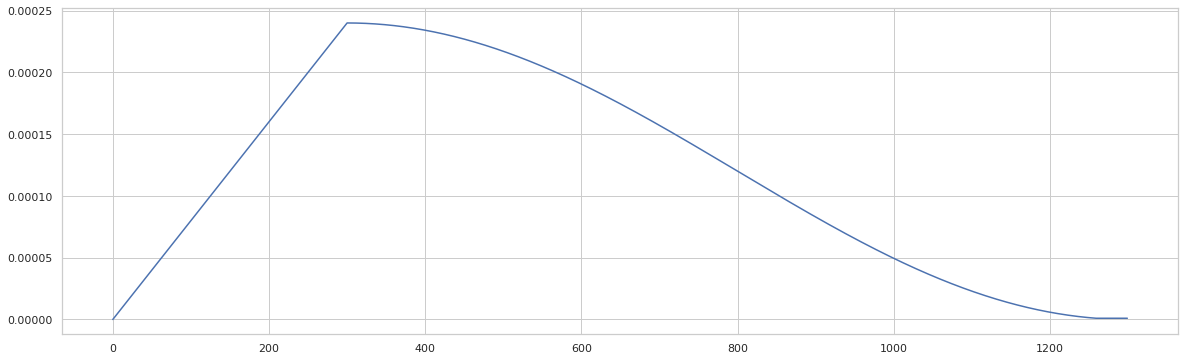

In [13]:
lr_start = 1e-8
lr_min = 1e-6
lr_max = LEARNING_RATE
num_cycles = 1
warmup_epochs = 3
hold_max_epochs = 0
total_epochs = EPOCHS
step_size = 100 #(NUM_TRAINING_IMAGES//BATCH_SIZE)
hold_max_steps = hold_max_epochs * step_size
total_steps = total_epochs * step_size
warmup_steps = warmup_epochs * step_size


def lrfn(total_steps, warmup_steps=0, lr_start=1e-4, lr_max=1e-3, lr_min=1e-4, num_cycles=1.):
    @tf.function
    def cosine_with_hard_restarts_schedule_with_warmup_(step):
        """ Create a schedule with a learning rate that decreases following the
        values of the cosine function with several hard restarts, after a warmup
        period during which it increases linearly between 0 and 1.
        """

        if step < warmup_steps:
            lr = (lr_max - lr_start) / warmup_steps * step + lr_start
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            lr = lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
            if lr_min is not None:
                lr = tf.math.maximum(lr_min, float(lr))
        return lr
    return cosine_with_hard_restarts_schedule_with_warmup_

lrfn_fn = lrfn(total_steps, warmup_steps, lr_start, lr_max, lr_min, num_cycles)
rng = [i for i in range(total_steps)]
y = [lrfn_fn(tf.cast(x, tf.float32)) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{total_steps} total steps and {step_size} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Training

In [14]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; oof_names = []; oof_folds = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if fold >= FOLDS_USED:
        break
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    TRAIN_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_CBB = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_CBSD = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_CGM = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_Healthy = tf.io.gfile.glob([GCS_PATH_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])
    
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAIN_FILENAMES)
    
    ct_train = count_data_items(TRAIN_FILENAMES)
    ct_valid = count_data_items(VALID_FILENAMES)
#     step_size = (ct_train // BATCH_SIZE)
#     warmup_steps = (warmup_epochs * step_size)
#     total_steps = (total_epochs * step_size)

    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        unfreeze_model(model) # unfreeze all layers except "batch normalization"

        lrfn_fn = lrfn(total_steps, warmup_steps, lr_start, LEARNING_RATE, lr_min, num_cycles)
        optimizer = optimizers.Adam(learning_rate=lambda: lrfn_fn(tf.cast(optimizer.iterations, tf.float32)))
        model.compile(optimizer=optimizer, 
                      loss={'output': losses.CategoricalCrossentropy(label_smoothing=.3)}, 
                      metrics={'output': metrics.CategoricalAccuracy()})
    
    model_path = f'model_{fold}.h5'
    ckpoint = ModelCheckpoint(model_path, mode='max', verbose=0, 
                              save_best_only=True, save_weights_only=True, 
                              monitor='val_categorical_accuracy')
    es = EarlyStopping(patience=ES_PATIENCE, mode='max', 
                       restore_best_weights=True, verbose=1, 
                       monitor='val_categorical_accuracy')
    history = model.fit(x=get_dataset(TRAIN_FILENAMES, repeated=True, augment=True, batch_size=BATCH_SIZE, sparse=False), 
                        validation_data=get_dataset(VALID_FILENAMES, ordered=True, batch_size=BATCH_SIZE, sparse=False), 
                        steps_per_epoch=step_size, 
                        epochs=EPOCHS, 
                        callbacks=[ckpoint, es], 
                        verbose=2).history
    
    
    ### RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_categorical_accuracy']):.3f}")
    
    history_list.append(history)
    # Load best model weights
    model.load_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True)
    oof_folds.append(np.full((ct_valid), fold, dtype='int8'))
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, target: image)
    oof_pred.append(model.predict(x_oof))
    # OOF names
    ds_valid_names = get_dataset(VALID_FILENAMES, labeled=False, ordered=True)
    oof_names.append(np.array([img_name.numpy().decode('utf-8') for img, img_name in iter(ds_valid_names.unbatch())]))


FOLD: 1
TRAIN: [ 0  2  3  4  5  7  9 10 11 12 13 14] VALID: [1 6 8]
Epoch 1/13
100/100 - 133s - loss: 1.3185 - categorical_accuracy: 0.6164 - val_loss: 1.1155 - val_categorical_accuracy: 0.8025
Epoch 2/13
100/100 - 48s - loss: 1.0912 - categorical_accuracy: 0.8358 - val_loss: 1.0572 - val_categorical_accuracy: 0.8521
Epoch 3/13
100/100 - 46s - loss: 1.0587 - categorical_accuracy: 0.8641 - val_loss: 1.0360 - val_categorical_accuracy: 0.8743
Epoch 4/13
100/100 - 43s - loss: 1.0376 - categorical_accuracy: 0.8782 - val_loss: 1.0325 - val_categorical_accuracy: 0.8771
Epoch 5/13
100/100 - 43s - loss: 1.0298 - categorical_accuracy: 0.8862 - val_loss: 1.0273 - val_categorical_accuracy: 0.8808
Epoch 6/13
100/100 - 44s - loss: 1.0197 - categorical_accuracy: 0.8934 - val_loss: 1.0267 - val_categorical_accuracy: 0.8785
Epoch 7/13
100/100 - 44s - loss: 1.0131 - categorical_accuracy: 0.8990 - val_loss: 1.0200 - val_categorical_accuracy: 0.8881
Epoch 8/13
100/100 - 43s - loss: 1.0026 - categorical_a

## Model loss graph


FOLD: 1


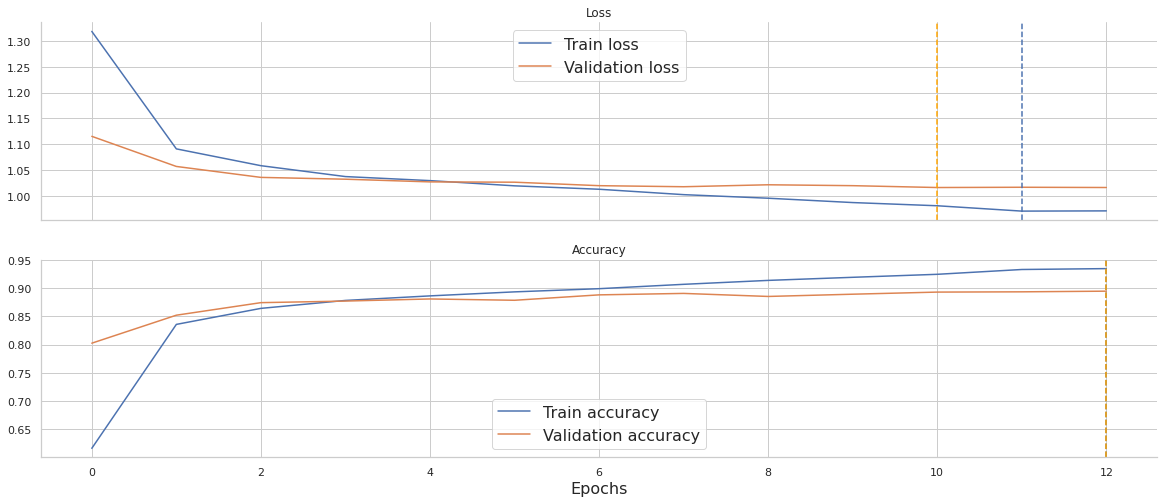

In [15]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history, acc_name='categorical_accuracy')

# Model evaluation

In [16]:
y_true = np.concatenate(oof_labels)
# y_true = np.argmax(y_true, axis=-1)
y_prob = np.concatenate(oof_pred)
y_pred = np.argmax(y_prob, axis=-1)
folds = np.concatenate(oof_folds)
names = np.concatenate(oof_names)

acc = accuracy_score(y_true, y_pred)
print(f'Overall OOF Accuracy = {acc:.3f}')

df_oof = pd.DataFrame({'image_id':names, 'fold':fold, 
                       'target':y_true, 'pred':y_pred})

df_oof = df_oof.assign(probs=[prob for prob in y_prob])
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())

print(classification_report(y_true, y_pred, target_names=CLASSES))

Overall OOF Accuracy = 0.895


,image_id,fold,target,pred,probs
0,1000201771.jpg,0,3,3,"[0.059567608, 0.06186193, 0.06363531, 0.754676..."
1,1000837476.jpg,0,3,3,"[0.061494637, 0.06301997, 0.062019724, 0.74856..."
2,1001723730.jpg,0,4,0,"[0.7373624, 0.08142834, 0.05188155, 0.06439338..."
3,1001749118.jpg,0,3,3,"[0.061232764, 0.061243024, 0.061154317, 0.7496..."
4,1008284502.jpg,0,3,3,"[0.057956237, 0.059508726, 0.057435513, 0.7647..."


                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.67      0.69      0.68       217
Cassava Brown Streak Disease       0.84      0.83      0.83       437
        Cassava Green Mottle       0.84      0.83      0.83       478
      Cassava Mosaic Disease       0.96      0.97      0.96      2633
                     Healthy       0.76      0.70      0.73       514

                    accuracy                           0.89      4279
                   macro avg       0.81      0.81      0.81      4279
                weighted avg       0.89      0.89      0.89      4279



# Confusion matrix

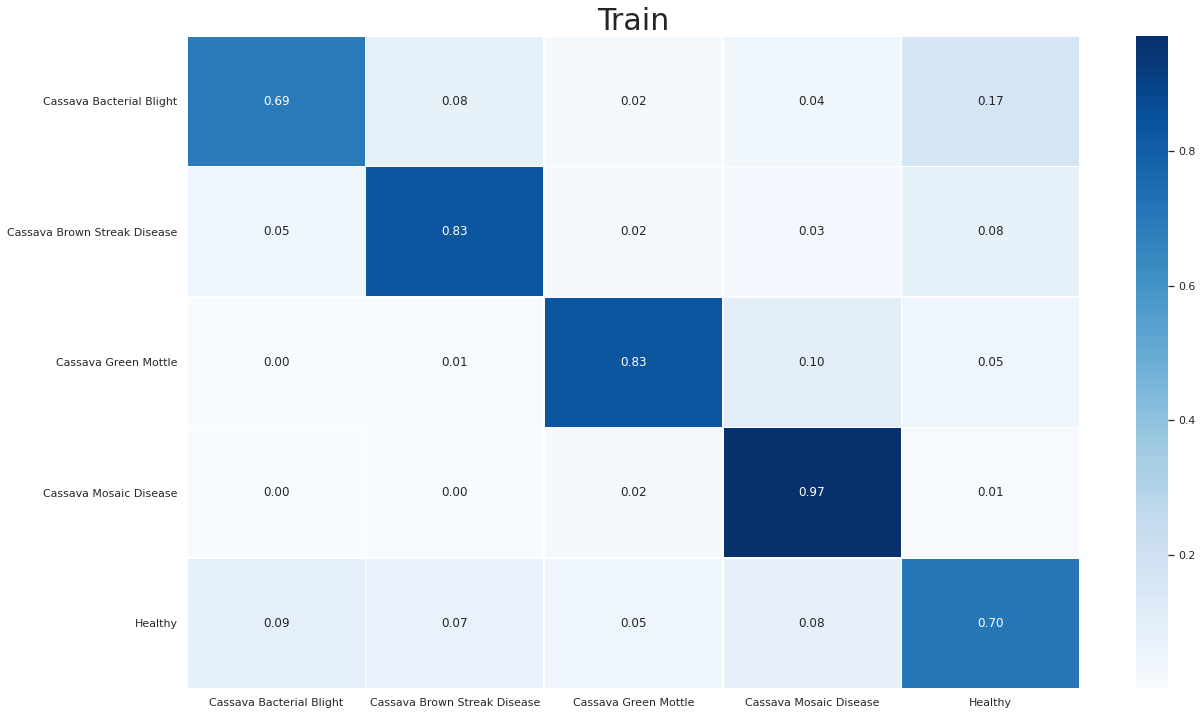

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('Train', fontsize=30)
plt.show()

# Visualize predictions

In [18]:
# train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)
# x_samp, y_samp = dataset_to_numpy_util(train_dataset, 18)
# y_samp = np.argmax(y_samp, axis=-1)

# x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
# samp_preds_1 = model.predict(x_samp_1, batch_size=9)
# display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

# x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
# samp_preds_2 = model.predict(x_samp_2, batch_size=9)
# display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)